# Inventory Monitoring Project
Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects. In this project, we will have to build a model that can count the number of objects in each bin. A system like this can be used to track inventory and make sure that delivery consignments have the correct number of items.

The Amazon Bin Image Dataset contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations.

Images are located in the bin-images directory, and metadata for each image is located in the metadata directory. Images and their associated metadata share simple numerical unique identifiers. For example, the metadata for the image at https://aft-vbi-pds.s3.amazonaws.com/bin-images/523.jpg is found at https://aft-vbi-pds.s3.amazonaws.com/metadata/523.json.

In [3]:
%%capture
!pip install smdebug torch torchvision tqdm --no-cache-dir

In [4]:
import sagemaker
import boto3
import os
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs,ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
import time
from PIL import Image
import io
from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug.trials import create_trial
from sagemaker.pytorch import PyTorchModel
from smdebug.core.modes import ModeKeys
from sagemaker.predictor import Predictor

[2023-04-19 03:13:07.772 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them.

In [5]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:44,  7.47it/s]

  0%|          | 1/2299 [00:00<05:03,  7.56it/s]

  0%|          | 2/2666 [00:00<03:02, 14.60it/s]

  0%|          | 1/2373 [00:00<04:13,  9.36it/s]

  0%|          | 2/1875 [00:00<02:22, 13.13it/s]

100%|██████████| 1875/1875 [03:12<00:00,  9.72it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [8]:
# Print statistics about the dataset
import os
train_path = "./train_data"
main_dirs = os.listdir(train_path)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(train_path, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'There are {num_items[directory]} images with {directory} items.')

There are 1228 images with 1 items.
There are 2299 images with 2 items.
There are 2666 images with 3 items.
There are 2373 images with 4 items.
There are 1875 images with 5 items.


## Resize Images
ResNet50 is a convolutional neural network architecture that takes input images of a fixed size, usually 224x224 or 256x256 pixels. Images in dataset are about 600px x 600px. so we need to resize them to get consistent result.

In [9]:
from PIL import Image
import os

dir_path = "./train_data"
resized_img_dir = "./train_data_resize/"

os.makedirs(resized_img_dir, exist_ok=True)

for i in ['1', '2', '3', '4', '5']:
    os.makedirs(os.path.join(resized_img_dir, i), exist_ok=True)
    for filename in os.listdir(os.path.join(dir_path, i)):
        if os.path.isfile(os.path.join(dir_path, i, filename)):
            Image.open(os.path.join(dir_path, i, filename)).convert('RGB').resize((224,224),Image.BILINEAR).save(os.path.join(resized_img_dir,i,filename))

## Data Distribution Plot

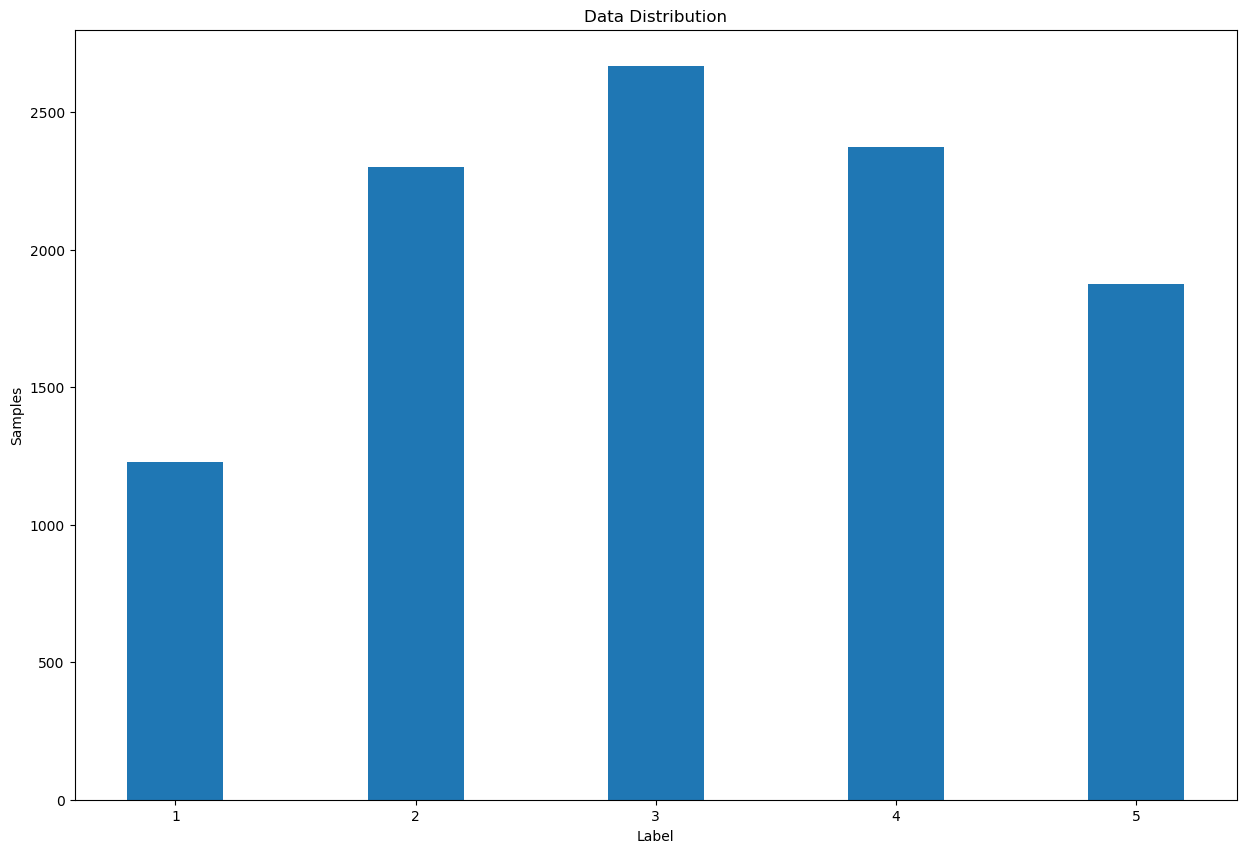

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'1':1228, '2':2299, '3':2666,'4':2373, '5':1875}
count = list(data.keys())
samples = list(data.values())

fig = plt.figure(figsize = (15, 10))

# creating the bar plot
plt.bar(count, samples, width = 0.4)

plt.xlabel("Label")
plt.ylabel("Samples")
plt.title("Data Distribution")
plt.show()

## Data Split
We will divide dataset into train, test and validation subsets. Each subset will as follows: Train: 60%, Test: 20%, Validation: 20%

In [11]:
import os
import random
import shutil
from math import floor

def split_data():
    dir_path = r'./train_data_resize'

    for i in ['1', '2', '3', '4', '5']:
        for split_type in ['train', 'valid', 'test']:
            directory_path = os.path.join('train_data_split', split_type, i)
            os.makedirs(directory_path, exist_ok=True)
        
        file_list = os.listdir(os.path.join(dir_path, i))
        file_list = [f for f in file_list if not f.startswith('.')]
        random.shuffle(file_list)

        train_size, test_size = map(lambda x: floor(len(file_list) * x), [.6, .2])
        train_list, valid_list, test_list = file_list[:train_size+1], file_list[train_size+1:train_size+test_size+1], file_list[train_size+test_size+1:]

        for filename, split_type in zip([train_list, valid_list, test_list], ['train', 'valid', 'test']):
            [shutil.copyfile(os.path.join(dir_path, i, file), os.path.join('train_data_split', split_type, i, file)) for file in filename]

split_data()

## Data Distribution After Resize and Split

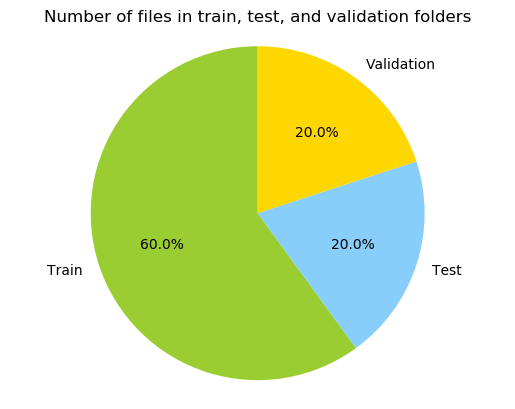

Number of files in train folder: 6267
Number of files in test folder: 2088
Number of files in validation folder: 2086


In [15]:
train_dir = "./train_data_split/train"
test_dir = "./train_data_split/test"
valid_dir = "./train_data_split/valid"

train_files = sum([len(files) for r, d, files in os.walk(train_dir)])
test_files = sum([len(files) for r, d, files in os.walk(test_dir)])
valid_files = sum([len(files) for r, d, files in os.walk(valid_dir)])

labels = ['Train', 'Test', 'Validation']
sizes = [train_files, test_files, valid_files]
colors = ['yellowgreen', 'lightskyblue', 'gold']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Number of files in train, test, and validation folders')
plt.show()

print("Number of files in train folder: {}".format(train_files))
print("Number of files in test folder: {}".format(test_files))
print("Number of files in validation folder: {}".format(valid_files))


### Upload to S3

In [16]:
role = sagemaker.get_execution_role()
bucket = 'udacitymlproject5'
s3_output_location = f"s3://{bucket}/models/image_model"
sagemaker_session = sagemaker.Session()
session = boto3.session.Session()
region = session.region_name

In [17]:
inputs = sagemaker_session.upload_data(path="train_data_split", bucket=bucket)

In [18]:
print(inputs)

s3://udacitymlproject5/data


## Hyperparameter Tuning
- We will launch a hyperparameter tuning job using the hpo.py script
- We will tune the learning rate and batch size
- We will use a ml.g4dn.xlarge instance to speed up the process


In [19]:
data_channels = {
    "train": f"s3://{bucket}/data/train/",
    "valid": f"s3://{bucket}/data/valid/",
    "test": f"s3://{bucket}/data/test/",
}

In [21]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [ ]:
#test on python script

In [26]:
os.environ["SM_CHANNEL_TRAIN"] = "train_data_split"
os.environ["SM_MODEL_DIR"] = '.'

!python hpo.py --learning_rate 0.1 --batch_size 32

Arguments: Namespace(batch_size=32, data='train_data_split', learning_rate=0.1, model_dir='.')
Hyperparameters are LR: 0.1, Batch Size: 32
Data Paths: train_data_split
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Starting Model Training
Epoch: 0, phase train
Epoch 0, Phase train, Images [32/6267 (1%)] Loss: 1.62 Accuracy: 7.0/32 (21.88%)
E

In [36]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3',
    output_path = "s3://udacitymlproject5/hpo-output/"
)

In [37]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type
)

In [39]:
tuner.fit(
    data_channels,
    wait = False
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateHyperParameterTuningJob operation: The account-level service limit 'ml.g4dn.xlarge for training job usage' is 2 Instances, with current utilization of 2 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

### Model Training with the best hyperparameters

In [40]:
BetterTrainingJobName='pytorch-training-230419-0434-003-9a0ea73d'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2023-04-19 04:52:56 Starting - Found matching resource for reuse
2023-04-19 04:52:56 Downloading - Downloading input data
2023-04-19 04:52:56 Training - Training image download completed. Training in progress.
2023-04-19 04:52:56 Uploading - Uploading generated training model
2023-04-19 04:52:56 Completed - Resource retained for reuse


In [41]:
best_hyperparameters = best_estimator.hyperparameters()
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}

hyperparameters

{'batch_size': 64, 'learning_rate': '0.013286582820793045'}

### Model Profiling and Debugging

In [42]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [43]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [52]:
hyperparameters = {
    "batch_size": 64,
    "learning_rate": 0.013286582820793045
}

In [53]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [ ]:
estimator.fit(
    data_channels,
    wait = True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-19-05-44-57-385


2023-04-19 05:45:08 Starting - Starting the training job...
2023-04-19 05:45:23 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-04-19 05:46:35 Downloading - Downloading input data......
2023-04-19 05:47:35 Training - Downloading the training image...............
2023-04-19 05:50:09 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-19 05:49:57,807 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-19 05:49:57,835 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-19 05:49:57,838 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-19 05:49:58,131 sagemaker-training-toolkit INFO    

In [55]:
job_name = estimator._current_job_name
print('Job:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug path', debug_artifacts_path)

Job: pytorch-training-2023-04-19-05-44-57-385
Debug path s3://sagemaker-us-east-1-262964915389/pytorch-training-2023-04-19-05-44-57-385/debug-output


In [56]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(debug_artifacts_path)

[2023-04-19 06:57:29.472 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-262964915389/pytorch-training-2023-04-19-05-44-57-385/debug-output
[2023-04-19 06:57:30.035 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 234 more expected)', IncompleteRead(0 bytes read, 234 more expected)) while reading s3://sagemaker-us-east-1-262964915389/pytorch-training-2023-04-19-05-44-57-385/debug-output/index/000000000/000000000027_worker_0.json . Will retry now


In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name,filename):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig(filename)

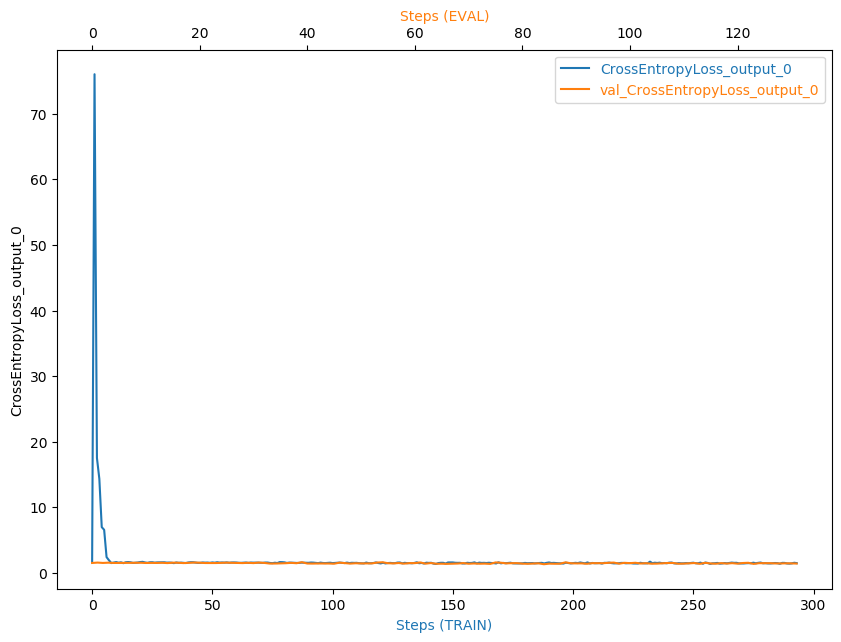

In [62]:
plot_tensor(trial, "CrossEntropyLoss_output_0","CrossEntropyLoss_output_0.png")

### Model Deploying and Querying

In [65]:
model_loc=estimator.model_data

In [78]:
print(model_loc)

s3://sagemaker-us-east-1-262964915389/pytorch-training-2023-04-19-05-44-57-385/output/model.tar.gz


In [66]:
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [88]:
pytorch_model = PyTorchModel(model_data=model_loc, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-19-09-32-53-905
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-19-09-32-54-700
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-19-09-32-54-700


----!

In [93]:
print(predictor.endpoint_name)

pytorch-inference-2023-04-19-09-32-54-700


In [87]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-19-09-04-10-528
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-19-09-04-10-528
